<a href="https://colab.research.google.com/github/mniab/PairsTradingStrategy/blob/main/Trading_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trading Strategies

In [ ]:
!pip install yfinance

In [ ]:
# import the libraries

import numpy as np
import pandas as pd
import statsmodels
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint   
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import datetime
from functools import cmp_to_key
import yfinance as yf

#Pairs Formation Period

We download the stock prices data from year 2011-2017 and use them to form the pairs with least Euclidean Distance (for the Distance Approach) and with the least p_value (for Cointegrated Approach). 

In [ ]:
# predefined functions in this cell ,  no need to chagne them

def downloadStockData(tickers,start,end):
    """
        This function downloads the Close price of the stock and creates a dataframe from it
        Params:
            tickers : a list of ticker of various stocks
            start   : it is the start date of the data to be downloaded. It is a datetime in datetime format.
            end     : it is the end date of the data to be downloaded. It is a datetime in datetime format.

        Return:
            A dataframe with all the close for of each stock on each open market day
    """
    ticker_data = yf.download(tickers, start, end)['Adj Close']
    return ticker_data


In [ ]:
tickers = ['HD', 'DIS','MSFT', 'BA', 'MMM', 'PFE', 'NKE', 'JNJ', 'MCD', 'XOM', 'GS', 'JPM', 'AXP', 'V', 'IBM', 'UNH', 'PG', 'GE', 'KO', 'CSCO', 'CVX', 'CAT', 'MRK', 'WMT', 'VZ', 'RTX', 'TRV', 'AAPL', 'ADBE', 'EBAY', 'QCOM', 'HPQ', 'JNPR', 'AMD']
start = datetime.datetime(2011,1,1)
end = datetime.datetime(2017,1,1)
data = downloadStockData(tickers,start,end)

[*********************100%***********************]  34 of 34 completed


In [ ]:
data.head(5)

,AAPL,ADBE,AMD,AXP,BA,CAT,CSCO,CVX,DIS,EBAY,GE,GS,HD,HPQ,IBM,JNJ,JNPR,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,QCOM,RTX,TRV,UNH,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,10.121364,31.290001,8.47,37.053566,53.034519,70.555496,15.108664,60.560432,33.302662,11.650193,13.363601,147.410355,27.752161,14.596128,103.839554,46.264698,31.679735,32.570312,23.526991,56.616985,65.234962,24.124914,22.143803,18.973982,11.382956,46.969040,37.678238,38.681416,43.204128,31.579218,16.358353,22.311430,42.486691,49.738258
2011-01-04,10.174186,31.510000,8.77,37.523151,53.465816,70.225761,15.130785,60.336464,34.332928,11.564886,13.604854,147.435974,27.249155,14.900073,103.952209,46.655025,31.611683,33.041683,23.039997,54.924381,65.144775,24.332428,22.230862,18.506742,11.582543,47.099556,38.271427,38.745079,43.010635,31.868374,16.376905,22.758516,42.650211,49.971779
2011-01-05,10.257413,32.220001,8.91,38.611893,53.897121,70.832756,15.315130,60.231094,35.187054,11.670504,13.626779,148.219635,27.162695,15.094730,103.536774,46.625572,32.224182,33.445736,22.902920,55.183079,65.144775,24.472992,22.159628,18.627964,11.659802,46.990795,39.067345,38.798927,42.755219,31.970446,16.722530,23.070860,42.369881,49.838333
2011-01-06,10.249121,32.270000,8.69,38.346146,54.951427,70.098366,15.447851,59.737068,34.914082,11.544577,13.568295,146.694839,27.052656,15.326963,104.670395,46.551922,32.504902,33.281132,22.736982,54.850475,64.746407,24.807693,22.808588,18.460466,11.704867,46.911018,39.547890,38.759762,42.097328,32.633835,16.973059,22.480158,42.019444,50.158588
2011-01-07,10.322517,32.040001,8.83,38.028946,55.414692,70.240730,15.462597,60.066410,34.737968,11.252103,13.473257,145.400024,27.021229,15.398674,104.156418,46.102676,31.977488,32.652607,22.697302,54.968742,64.814056,25.001818,22.634483,18.409769,11.807885,46.773239,38.842075,38.725502,41.276901,32.701866,16.924347,22.294006,42.112896,50.432137


In all the below functions we will do the trade on the similar stocks based upon different strategy which revolve around the central idea of pairs trading strategy. 

In [ ]:
def normalize(x):
  return (x-x.mean())/x.std()

In [ ]:
def trade1(S1, S2, window ,MAX_SHORTING_AMOUNT=10000, MAX_TRANSACTION_AT_A_TIME=5,c1=1,c2=0.75):
    """
        This functions performs the trading according to the following strategy
            For the distance approach , we will use the mean and standard deviation . If the ratio(Y/X) between the time series at any point becomes such that it is greater 
            than the mean+c_1*standard deviation  we will short the stock Y and go for long X and square off whenever the ratio becomes less than   mean+ c_2*standard deviation, 
            where c1 and c2 are constant here ,  like c_1=1, c_1=0.5 ,etc. Note c_1>c_2 If the ratio becomes less than the mean - c1*standard deviation , we will follow the reverse strategy .
        Params: 
            data1                     : Time series data of stock 1
            data2                     : Time series data of stock 2
            window                    : The size of the datapoints from which we calculate the mean and standard deviation for each time 
            MAX_SHORTING_AMOUNT       : The maximum amount of money , for which the stocks can be shorted at a time
            MAX_TRANSACTION_AT_A_TIME : the number of times we can short a stock , in each shorting we do the shorting worth  MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            c1                        : A constant with usage stated above 
            c2                        : A constant with usage stated above
        Return:
            The profit which we can make by using this method
    """
 
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma = ratios.rolling(window=window,
                               center=False).mean()
   
    std = ratios.rolling(window=window,
                        center=False).std()
    
    # Simulate trading
    # Start with no money and no positions
    money=0
    countS1 = 0
    countS2 = 0
    num_of_trans = 0
    for i in range(window-1,len(ratios)-1):
        # Sell short if the z-score is > 1
        if ratios[i] > (ma[i]+c1*std[i]) and num_of_trans <= MAX_TRANSACTION_AT_A_TIME :
            num_of_trans +=1
            amount = MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            countS1 -= amount/S1[i] 
            countS2 += amount/S2[i]
        elif ratios[i] < (ma[i] - c1*std[i]) and num_of_trans <= MAX_TRANSACTION_AT_A_TIME :  # ma[i]-c1*std[i]   ma-c2 <x<ma+c2*std
            num_of_trans +=1
            amount = MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            countS1 += amount/S1[i] 
            countS2 -= amount/S2[i]
        elif ratios[i] <= ma[i]+c2*std[i] and ratios[i] >= ma[i]-c2*std[i]:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            num_of_trans = 0
        
    #Squaring off all transactions
    money += S1[len(ratios)-1] * countS1 + S2[len(ratios)-1] * countS2

            
    return money
    

In [ ]:
def trade2(S1, S2, window ,MAX_SHORTING_AMOUNT=10000, MAX_TRANSACTION_AT_A_TIME=5,c1=1,c2=0.75):
    """
        This functions performs the trading according to the following strategy
            For the distance approach , we will use the mean and standard deviation . If the distance(Y-X) between the time series at any point becomes such that it is greater 
            than the mean+c_1*standard deviation  we will short the stock Y and go for long X and square off whenever the distance becomes less than   mean+ c_2*standard deviation, 
            where c1 and c2 are constant here ,  like c_1=1, c_1=0.5 ,etc. Note c_1>c_2 If the distance becomes less than the mean - c1*standard deviation , we will follow the reverse strategy .
        Params: 
            data1                     : Time series data of stock 1
            data2                     : Time series data of stock 2
            window                    : The size of the datapoints from which we calculate the mean and standard deviation for each time 
            MAX_SHORTING_AMOUNT       : The maximum amount of money , for which the stocks can be shorted at a time
            MAX_TRANSACTION_AT_A_TIME : the number of times we can short a stock , in each shorting we do the shorting worth  MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            c1                        : A constant with usage stated above 
            c2                        : A constant with usage stated above
        Return:
            The profit which we can make by using this method
    """
     # Compute rolling mean and rolling standard deviation
    S1 = normalize(S1)
    S2 = normalize(S2)
    diff = S1 - S2
    ma = diff.rolling(window=window,
                               center=False).mean()
   
    std = diff.rolling(window=window,
                        center=False).std()
    
    # Simulate trading
    # Start with no money and no positions
    money=0
    countS1 = 0
    countS2 = 0
    num_of_trans = 0
    for i in range(window-1,len(diff)-1):
        # Sell short if the z-score is > 1
        if diff[i] > (ma[i]+c1*std[i]) and num_of_trans <= MAX_TRANSACTION_AT_A_TIME :
            num_of_trans +=1
            amount = MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            countS1 -= amount/S1[i] 
            countS2 += amount/S2[i]
        elif diff[i] < (ma[i] - c1*std[i]) and num_of_trans <= MAX_TRANSACTION_AT_A_TIME :  
            num_of_trans +=1
            amount = MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            countS1 += amount/S1[i] 
            countS2 -= amount/S2[i]
        elif diff[i] <= ma[i]+c2*std[i] and diff[i] >= ma[i]-c2*std[i]:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            num_of_trans = 0


    #Squaring off all transactions

    money += S1[len(S1)-1] * countS1 + S2[len(S2)-1] * countS2

            
    return money

In [ ]:
def trade3(S1, S2,window, MAX_SHORTING_AMOUNT = 10000, MAX_TRANSACTION_AT_A_TIME=5,error_bound1=0.1,error_bound2=0.05):
    """
        This functions performs the trading according to the following strategy
            For the cointegration approach , we will use the fit a line and then calculate the errors . If the error ratio(Y/X) between the time series at any point becomes such that it is greater 
            than the error_bound1 (the error is calculated by fitting a line to the ratios data over the last <window> days) we will short the stock Y and go for long X and square off whenever the ratio
            becomes less than error_bound2 .If the ratio becomes less than the -1*error_bound1 , we will follow the reverse strategy .
        Params: 
            data1                     : Time series data of stock 1
            data2                     : Time series data of stock 2
            window                    : The size of the datapoints for which we fit a line and calculate the eror 
            MAX_SHORTING_AMOUNT       : The maximum amount of money , for which the stocks can be shorted at a time
            MAX_TRANSACTION_AT_A_TIME : the number of times we can short a stock , in each shorting we do the shorting worth  MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            error_bound1              : A constant with usage stated above 
            error_bound2              : A constant with usage stated above
        Return:
            The profit which we can make by using this method
    """

    ratios = S1/S2
    money = 0
    countS1=0
    countS2=0
    num_of_trans=0
    for i in range(len(ratios)-window-1):
      Y = ratios[i:i+window]
      X = np.array(range(i+1,window+i+1))
      X = X.reshape(-1,1)
      model = LinearRegression().fit(X,Y)
      y_pred = model.predict([[ratios[i+window]]])
      error = ratios[i+window] - y_pred
      if error > error_bound1 and num_of_trans <= MAX_TRANSACTION_AT_A_TIME :
        amount = MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
        num_of_trans+=1
        countS1 -= amount/S1[i+window]
        countS2 += amount/S2[i+window]
      elif error < -error_bound1 and num_of_trans <= MAX_TRANSACTION_AT_A_TIME:
        amount = MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
        num_of_trans+=1
        countS1 += amount/S1[i+window]
        countS2 -= amount/S2[i+window]

      elif error > -error_bound2 and error < error_bound2 :
        money += S1[i+window] * countS1 + S2[i+window] * countS2
        countS1 = 0
        countS2 = 0
        num_of_trans = 0
    #Squaring off all transactions
    money += S1[len(ratios)-1] * countS1 + S2[len(ratios)-1] * countS2

    return money
    


In [ ]:
def trade4(S1, S2, window1=5, window2=60,MAX_SHORTING_AMOUNT=10000, MAX_TRANSACTION_AT_A_TIME=5,c1=1,c2=0.75):
    """
        This functions performs the trading according to the following strategy
            For the cointegration approach, we will use the moving averages to calculate the transactions to be done.
            First of all we calculate the moving average on window size of window1 and window2 and the moving standard deviation for window size of window2 for the ratio(Y/X) of stocks.
            Also we assume window1<window2
            Now when moving_average_window1 > moving_average_window2 + c1 * standard_deviation_window2 , we then short the stock Y and go for long on stock X and we would square off when
            moving_average_window1 < moving_average_window2 - c2 * standard_deviation_window2.  
            Reverse strategy happens when moving_average_window1 < moving_average_window2 - c1 * standard_deviation_window2
        Params:
            data1                     : Time series data of stock 1
            data2                     : Time series data of stock 2
            window1                   : The size of the data points from which we calculate the moving averages. This will be the less number of days moving average
            window1                   : The size of the data points from which we calculate the moving averages. This will be the more number of days moving average
            MAX_SHORTING_AMOUNT       : The maximum amount of money , for which the stocks can be shorted at a time
            MAX_TRANSACTION_AT_A_TIME : the number of times we can short a stock , in each shorting we do the shorting worth  MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
    """
     # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,center=False).mean()
    ma2 = ratios.rolling(window=window2,center=False).mean()
   
    std2 = ratios.rolling(window=window2,
                        center=False).std()
    
    # Simulate trading
    # Start with no money and no positions
    money=0
    countS1 = 0
    countS2 = 0
    num_of_trans = 0
    for i in range(window2-1,len(ratios)):
        if ma1[i] > (ma2[i]+c1*std2[i]) and num_of_trans <= MAX_TRANSACTION_AT_A_TIME :
            num_of_trans +=1
            amount = MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            countS1 -= amount/S1[i] 
            countS2 += amount/S2[i]
        elif ma1[i] < (ma2[i] - c1*std2[i]) and num_of_trans <= MAX_TRANSACTION_AT_A_TIME :  
            num_of_trans +=1
            amount = MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            countS1 += amount/S1[i] 
            countS2 -= amount/S2[i]
        elif ma1[i] <= ma2[i]+c2*std2[i] and ma1[i] >= ma2[i]-c2*std2[i]:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            num_of_trans = 0

    #Squaring off all transactions
    money += S1[len(ratios)-1] * countS1 + S2[len(ratios)-1] * countS2

    return money


In [ ]:
def findCointegrationValue(data,p_value_threshold=0.05):
    """
        This function find out the pairs of stock with p value less than a constant
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            p_value_threshold  : the threshold value for the p value of pairs of stocks. We consider a 2 stocks to be cointegrted only if the p value is less than this value

        Returns:
            p values of all the pairs , the list of all the pairs with p value less than the threshold 
    """
    n = data.shape[1]
    p_values_matrix = np.ones((n,n));
    keys = data.keys();
    pairs = []
    for i in range(n):
      for j in range(i+1,n):
        S1 = data[keys[i]]
        S2 = data[keys[j]]
        result = coint(S1,S2)
        score = result[0]
        pvalue = result[1]
        p_values_matrix[i,j]=pvalue
        if(pvalue < p_value_threshold):
          pairs.append(((i,j),pvalue))
        
    return p_values_matrix,pairs

In [ ]:
def zscore(series):
    newSeries = series.copy()
    for i in range(len(newSeries)):
        x = (newSeries[i] - newSeries[:i+1].mean()) / np.std(newSeries[:i+1])
        series[i]= x
    return series

In [ ]:
def compare(x,y):
  return x[1]-y[1]

In [ ]:
def getBestKCointergratedStocks(data,k=10,p_value_threshold=0.05):
    """
        This functions find out the k pairs with the least p value and all of them should be less than the threshold  
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            k                  : the number of pairs to be found out
            p_value_threshold  : the threshold value for the p value of pairs of stocks. We consider a 2 stocks to be cointegrted only if the p value is less than this value

        Returns:
            the p value for all the pairs of stocks , the list k pairs with the least p value and their p values . If k such pairs doesn't exists return how many of them occur 
    """
    p_values_matrix, pairs = findCointegrationValue(data)
    tem=sorted(pairs,key=cmp_to_key(compare))
    if len(tem) < k:
      return p_values_matrix,tem
    return p_values_matrix,tem[0:k]
   

In [ ]:
def normalize(series):
  return series-series.min()/(series.max()-series.min())

In [ ]:
def distanceBetweenStocks(data1,data2,window_size):
    """
        This function takes list of two stocks and find the distance between the stocks 
        Params:
            data1: list of stock price of stock1
            data2: list of stock price of stock2
            window_size : the window size
        Returns:
            the distance between the lists

        Note:
            In this function do try to normalise the stock price and try out some variations in it.
    """
    data1 = normalize(data1)
    data2 = normalize(data2)
    distance=0 
    for i in range(len(data1)):
      distance += (data1[i] - data2[i])**2
    
    return distance


In [ ]:
def getBestKLessDistanceStocks(data,k=10):
    """
        This functions find out the k pairs with the least distance between them  
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            k                  : the number of pairs to be found out
            
        Returns:
            the distance between all the stock pairs, the list of k pairs with the least distance between them
    """
    n = data.shape[1]
    keys=data.keys();
    pairs=[]
    _distance=np.ones((n,n))
    for i in range(n):
      for j in range (i+1,n):
        d1=data[keys[i]]
        d2=data[keys[j]]
        ans=distanceBetweenStocks(d1,d2,100)
        _distance[i][j]=ans
        pairs.append(((i,j),ans))
    
    pairs.sort(key=cmp_to_key(compare))
    if(len(pairs)<k):
      return _distance,pairs
    return _distance,pairs[0:k]

In [ ]:
_,distance_pair = getBestKLessDistanceStocks(data,1)

In [ ]:
_, cointegrated_pair = getBestKCointergratedStocks(data,1)
keys  = data.keys()

In [ ]:
distance_pair

[((10, 24), 5306.63413400654)]

In [ ]:
cointegrated_pair

[((6, 28), 0.00217013760574349)]

In [ ]:
distance_cmp1 = keys[distance_pair[0][0][0]]
distance_cmp2 = keys[distance_pair[0][0][1]]

print(f"Pairs with least Euclidean distance are {distance_cmp1} and {distance_cmp2}.")

Pairs with least Euclidean distance are GE and PFE.


In [ ]:
coint_cmp1 = keys[cointegrated_pair[0][0][0]]
coint_cmp2 = keys[cointegrated_pair[0][0][1]]
print(f"Pairs showing the highest cointegration are {coint_cmp1} and {coint_cmp2}.")

Pairs showing the highest cointegration are CSCO and TRV.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


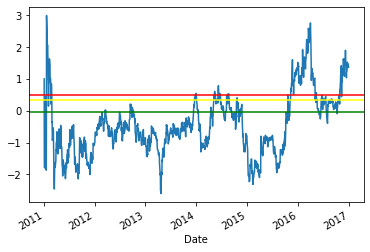

GE PFE


In [ ]:
S1=keys[distance_pair[0][0][0]]
S2=keys[distance_pair[0][0][1]]
ratios = data[S1]/data[S2]
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(),color="yellow")
plt.axhline(0.5, color="red")
plt.axhline(-0.05, color="green")
plt.show()
print(S1,S2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


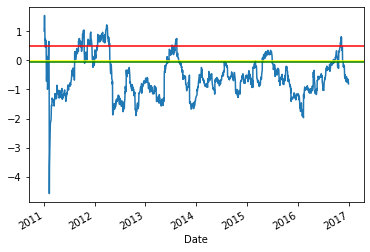

CSCO TRV


In [ ]:
S1=keys[cointegrated_pair[0][0][0]]
S2=keys[cointegrated_pair[0][0][1]]
ratios = data[S1]/data[S2]
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(),color="yellow")
plt.axhline(0.5, color="red")
plt.axhline(-0.05, color="green")
plt.show()
print(S1,S2)

#Trading Period

We used the stock price data of 6 years from 2011-2017 to form the pairs. Now we will trade them using the above strategies for stock price data from the year 2017 to 2019.

In [ ]:
distance_tickers = ['GE','PFE']
cointegraed_tickers = ['CSCO','TRV']
start = datetime.datetime(2017,1,1)
end = datetime.datetime(2019,1,1)
recent_distance_data = downloadStockData(distance_tickers,start,end)
recent_cointegrated_data = downloadStockData(cointegraed_tickers,start,end)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Results of various trading strategies for two approaches are as follows:

### Distance Approach

In [ ]:
print("Net gain/loss: ",trade1(recent_distance_data['GE'],recent_distance_data['PFE'],10))

Net gain/loss:  -2128.825786516014


In [ ]:
print("Net gain/loss: ",trade2(recent_distance_data['GE'],recent_distance_data['PFE'],10))

0 0
Net gain/loss:  -309.91136686383174


### Cointegrated Approach

In [ ]:
print("Net gain/loss: ",trade3(recent_cointegrated_data['CSCO'],recent_cointegrated_data['TRV'],10))

Net gain/loss:  1315.1256137450114


In [ ]:
print("Net gain/loss: ",trade4(recent_cointegrated_data['CSCO'],recent_cointegrated_data['TRV']))

Net gain/loss:  2461.723599962202
